# Introduction and Setup

In this project, we'll create simulations of two-dimensional heat diffusion using four different numerical methods. By comparing their computational performance, we'll gain insights into which approach is best suited for various scenarios.

Let's begin by importing the necessary libraries:

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import inspect
import jax
import jax.numpy as jnp
import time

For this project, we are using the following parameters: `N`, which notes the grid size of the simulation, and `epsilon`, a small positive number that controls the timescale of the approximation.

In [2]:
N = 101
epsilon = 0.2

We will set up the initial solution by putting 1 unit of heat at the center of the grid.

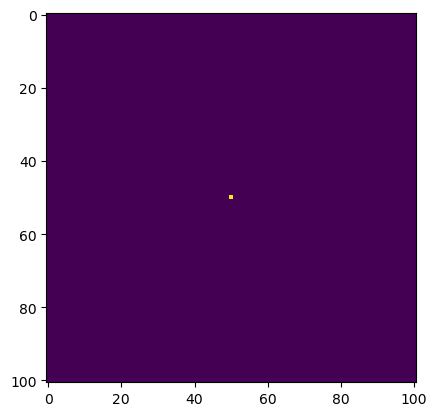

In [3]:
# construct initial condition
u0 = np.zeros((N, N))
u0[int(N/2), int(N/2)] = 1.0
plt.imshow(u0)

# Simulation With Matrix Multiplication

We'll first use matrix-vector multiplication to simulate the heat diffusion in the 2D space. The vector here is created by flattening the current solution ${u^k_{i, j}}$. Here, k is referring to the time step since the diffusion starts, and ${u_{i,j}}$ represents the temperature at position $(i,j)$.

To implement this approach, we need two key functions:

## Define the Matrix-Vector Multiplication

First, we will write a function called `advance_time_matvecmul`, that advances the simulation by one timestep via matrix-vector multiplication.

In [4]:
from heat_equation import advance_time_matvecmul
print(inspect.getsource(advance_time_matvecmul))

def advance_time_matvecmul(A, u, epsilon):
    """Advances the simulation by one timestep, via matrix-vector multiplication
    Args:
        A: The 2d finite difference matrix, N^2 x N^2. 
        u: N x N grid state at timestep k.
        epsilon: stability constant.

    Returns:
        N x N Grid state at timestep k+1.
    """
    N = u.shape[0]
    u = u + epsilon * (A @ u.flatten()).reshape((N, N))
    return u



This function flattens the 2D grid into a vector, and calculates how heat flows between points using the finite difference matrix A.. After adjusting the result by epsilon, which controls simulation stability, we then add the change to the original heat values and reshape this diffusion state back to the original 2D grid.

## Create the Finite Difference Matrix A

In the function above, we notice the argument Matrix A, which is the 2D finite difference matrix. It encodes the relationship between each grid point and its neighbors. Here, we will use the function `get_A(N)`, which takes in an argument N that specifies and grid size and returns a corresponding matrix A.

In [5]:
from heat_equation import get_A
print(inspect.getsource(get_A))

def get_A(N):
    """
    constructs the 2d finite difference matrix for heat diffusion simulation
    argument: N: grid size (N*N)
    return: A: the N^2 * N^2 finite difference matrix
    """
    
    n = N * N
    diagonals = [-4 * np.ones(n), np.ones(n-1), np.ones(n-1), np.ones(n-N), np.ones(n-N)]
    diagonals[1][(N-1)::N] = 0
    diagonals[2][(N-1)::N] = 0
    
    # Construct matrix A
    A = np.diag(diagonals[0])                 # Main diagonal (-4)
    A += np.diag(diagonals[1], 1)             # Right neighbor
    A += np.diag(diagonals[2], -1)            # Left neighbor
    A += np.diag(diagonals[3], N)             # Bottom neighbor
    A += np.diag(diagonals[4], -N)            # Top neighbor
    
    return A



This function builds a special matrix that represents how heat flows between nearby points on our grid. Let's break down its structure:

- A main diagonal filled with -4's, which represents each point on the grid
- Four other diagonals filled with 1's, which represent the four neighboring points (right, left, bottom, top)
- Special adjustments for the boundary conditions (where heat can escape)

The matrix A connects all grid points together according to the heat equation rules, letting us calculate how heat spreads from each point to its neighbors.

## Running the Simulation
Let's run a total of 2700 iterations, and visualize the state of heat diffusion every 300 iterations. We will store each simulation state within a list called `simulations` and plot them in a 3×3 grid.

Simulation time: 36.653226137161255 seconds


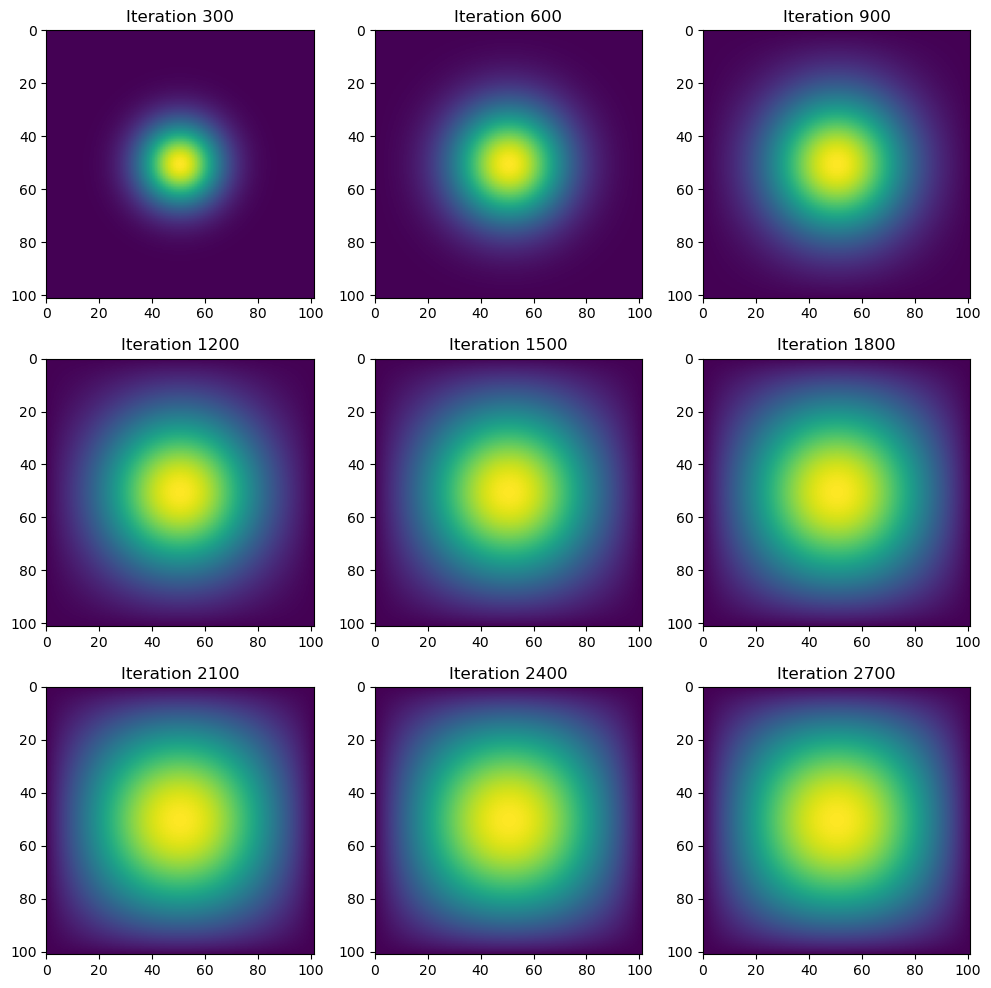

In [6]:
# Simulation parameters
iterations = 2700  # Total iterations
interval = 300  # Save every 300 iterations
A = get_A(N)

# Store intermediate solutions
simulations = []
u = u0.copy()  # Working copy of the grid
start_time = time.time()

# Run the simulation
for i in range(1, iterations + 1):
    u = advance_time_matvecmul(A, u, epsilon)
    if i % interval == 0:
        simulations.append(u.copy())  # Save the current state

end_time = time.time()
print(f"Simulation time: {end_time - start_time} seconds")

# Visualization
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    if i < len(simulations):
        im = ax.imshow(simulations[i], cmap='viridis', origin='lower', extent=[0, N, N, 0])
        ax.set_title(f"Iteration {(i+1) * interval}")
        ax.axis('on')
plt.tight_layout()
plt.show()

Notice that this simulation took some time to compile – 36.65 seconds. While we can use the underlying optimized matrix multiplication routine from BLAS (basic linear algebra subprograms), it is not particularly effective here, as matrix A a lot of zero elements, wasting time for computation. Will other methods generate visualizations faster than matrix multiplication?

# Simulation with Sparse Matrix in JAX

In the second method, let's use the data structure of sparse matrices. Sparse matrices are perfect for this problem because the finite difference matrix A has mostly zeros, and sparse formats store only non-zero elements, saving memory and computation time. We’ll also use JAX's JIT compilation to speed up the simulation.

## Create the Sparse Matrix A

Let’s define the function `get_sparse_A(N)`, a function that returns A_sp_matrix, the matrix A in a sparse format, given the grid size N as the input. Since most of A's elements are zero, we’ll store it in BCOO (Batched Coordinate) format, a sparse matrix format supported by JAX.

In [7]:
from heat_equation import get_sparse_A
print(inspect.getsource(get_sparse_A))

def get_sparse_A(N):
    """
    args:
        N: grid size (N*N)
    return:
        A_sp_matrix: matrix A in sparse (BCOO) format
    """
    n = N * N
    rows, cols, values = [], [], []

    # Main diagonal: -4 for each point
    for i in range(n):
        rows.append(i)
        cols.append(i)
        values.append(-4.0)

    # Right neighbors
    for i in range(n - 1):
        if (i + 1) % N != 0:  # Skip right boundary
            rows.append(i)
            cols.append(i + 1)
            values.append(1.0)

    # Left neighbors
    for i in range(1, n):
        if i % N != 0:  # Skip left boundary
            rows.append(i)
            cols.append(i - 1)
            values.append(1.0)

    # Bottom neighbors
    for i in range(n - N):
        rows.append(i)
        cols.append(i + N)
        values.append(1.0)

    # Top neighbors
    for i in range(N, n):
        rows.append(i)
        cols.append(i - N)
        values.append(1.0)

    # Convert to BCOO format
    indices = np.c

Here, we create lists for row indices (rows), column indices (cols), and values (values). Then fill these lists with the non-zero elements of A: the main diagonal has -4, and the neighboring diagonals have 1. Finally, we convert these lists into a sparse matrix in BCOO format using `sparse.BCOO`.

## Define the Sparse Matrix-Vector Multiplication

Next, we’ll use JAX's sparse matrix-vector multiplication to update the grid state. To make it fast, we’ll JIT-compile the function.

In [8]:
from heat_equation import advance_time_matvecmul_sparse
print(inspect.getsource(advance_time_matvecmul_sparse))

@jax.jit
def advance_time_matvecmul_sparse(A_sp, u_flat, epsilon):
    """
    args:
        A_sp: the sparse 2d finite difference matrix
        u_flat: the flattened NxN grid state at timestep k
        epsilon: stability constant
    returns:
        N x N Grid state at timestep k+1.
    """
    return u_flat + epsilon * (A_sp @ u_flat)



The function takes the sparse matrix A_sp, the flattened grid u_flat, and the stability constant epsilon. It computes the new grid state using sparse matrix-vector multiplication, and the result is scaled by epsilon and added to the current state, returning the grid state at timestep k+1.

## Running the Simulation
Now, let’s run the simulation for 2700 iterations, saving the grid state every 300 steps.

Simulation time (sparse): 0.5841178894042969 seconds


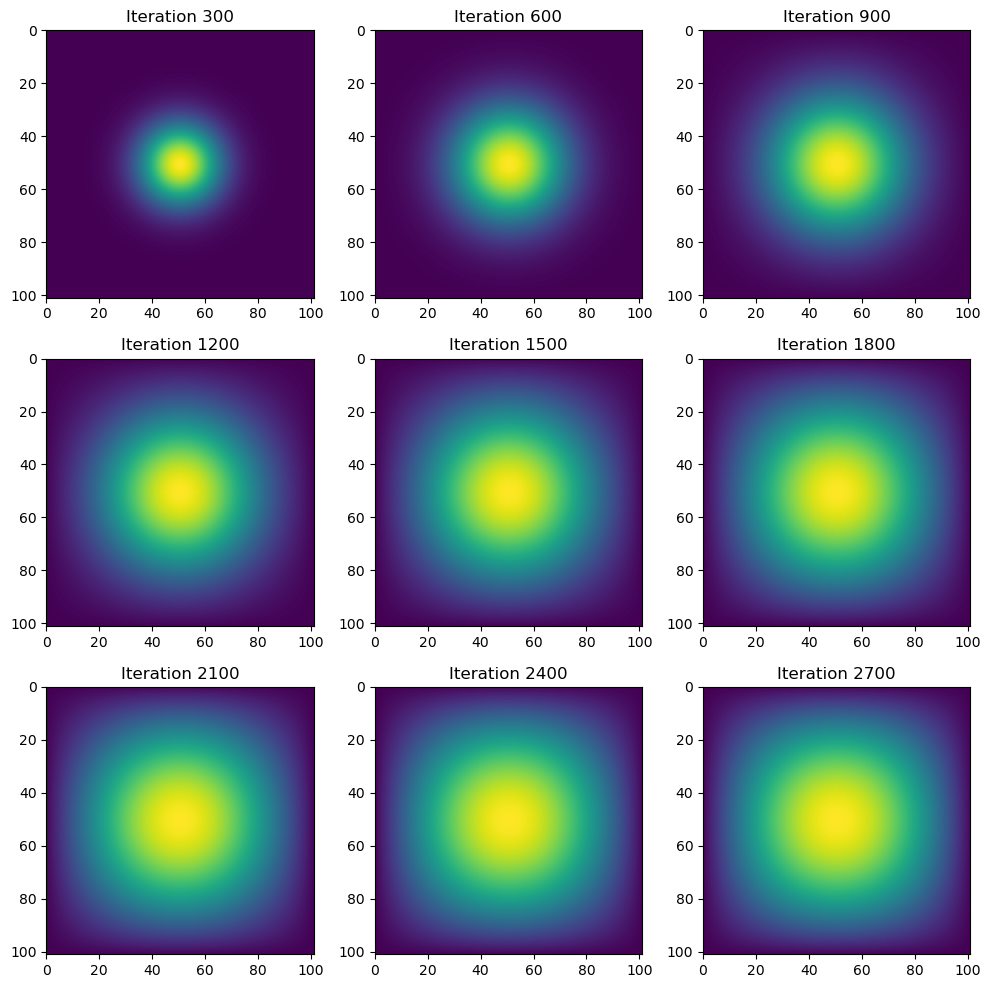

In [9]:
# Get sparse matrix A
A_sp = get_sparse_A(N)

# Store intermediate solutions
simulations = []
u_flat = u0.flatten()  # Flatten the grid for sparse multiplication
start_time = time.time()

# Run the simulation
for i in range(1, iterations + 1):
    u_flat = advance_time_matvecmul_sparse(A_sp, u_flat, epsilon)
    if i % interval == 0:
        simulations.append(u_flat.reshape((N, N)))  # Save the current state

end_time = time.time()
print(f"Simulation time (sparse): {end_time - start_time} seconds")

# Generate visualization
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    if i < len(simulations):
        im = ax.imshow(simulations[i], cmap='viridis', origin='lower', extent=[0, N, N, 0])
        ax.set_title(f"Iteration {(i+1) * interval}")
        ax.axis('on')
plt.tight_layout()
plt.show()

Looking at the time taken for compiling these visualizations, we notice that this only takes 0.58 seconds, which is much faster than the matrix multiplication method.

# Simulation with NumPy

For the third method, we’ll simplify the heat diffusion simulation by using vectorized array operations like `np.roll()` instead of matrix-vector multiplication. This approach avoids the need for sparse or dense matrices and is computationally efficient for the heat equation.

## Define the Advance Function
The function `advance_time_numpy` will update the grid state using vectorized operations. We’ll pad the grid with zeros to handle boundary conditions and use `np.roll()` to compute the finite differences.

In [10]:
from heat_equation import advance_time_numpy
print(inspect.getsource(advance_time_numpy))

def advance_time_numpy(u, epsilon):
    """
    Advances the solution by one timestep using vectorized array operations.
    
    Args:
        u: N x N grid state at timestep k.
        epsilon: Stability constant.
        
    Returns:
        N x N grid state at timestep k+1.
    """
    # Pad the grid with zeros to handle boundaries
    padded = np.pad(u, 1, mode='constant', constant_values=0)
    
    # Compute the finite differences using np.roll()
    u_new = u + epsilon * (
        np.roll(padded, 1, axis=0)[1:-1, 1:-1] +  # Top neighbor
        np.roll(padded, -1, axis=0)[1:-1, 1:-1] +  # Bottom neighbor
        np.roll(padded, 1, axis=1)[1:-1, 1:-1] +   # Left neighbor
        np.roll(padded, -1, axis=1)[1:-1, 1:-1] -  # Right neighbor
        4 * u                                       # Center
    )
    return u_new



We pad the grid u with zeros to create a (N+2) x (N+2) array. This handles the boundary conditions (no heat flow across boundaries). Then, we use `np.roll()` to shift the grid in four directions (top, bottom, left, right) and compute the finite differences. The new grid state u_new is updated using the 5-point stencil formula

## Running the Simulation
Now let's run the simulation again using the same parameters, visualizing every 300 steps in 2700 iterations.

Simulation time (NumPy): 0.20039105415344238 seconds


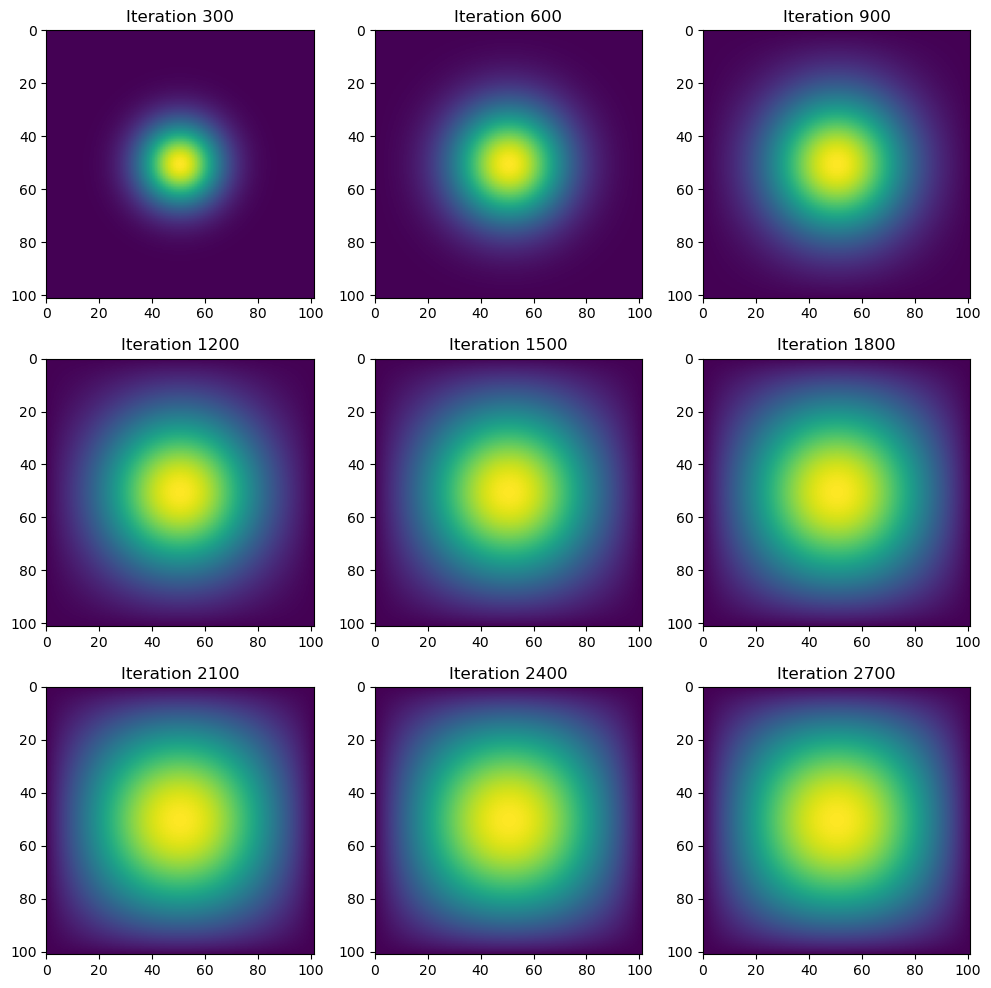

In [11]:
# Store intermediate solutions
simulations = []
u = u0.copy()  # Working copy of the grid
start_time = time.time()

# Run the simulation
for i in range(1, iterations + 1):
    u = advance_time_numpy(u, epsilon)
    if i % interval == 0:
        simulations.append(u.copy())  # Save the current state

end_time = time.time()
print(f"Simulation time (NumPy): {end_time - start_time} seconds")

# Generate visualization
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    if i < len(simulations):
        im = ax.imshow(simulations[i], cmap='viridis', origin='lower', extent=[0, N, N, 0])
        ax.set_title(f"Iteration {(i+1) * interval}")
        ax.axis('on')
plt.tight_layout()
plt.show()

Comparing to the previous two methods, we see that the numpy method generates visualization much faster than the first method, and also a little faster than the second method. Using numpy is simple and effective for simulating heat diffusion.

# Simulation with JAX

For the fourth method, let's use JAX to simulate heat diffusion with JIT compilation. JAX allows us to write NumPy-like code and compile it for high performance. We’ll define a function `advance_time_jax(u, epsilon)` that updates the grid state using vectorized operations, similar to `advance_time_numpy()`, but with JIT compilation for speed.

## Define the Advance Function

We’ll use JAX's `jnp.roll()` to compute finite differences, just like `np.roll()` in NumPy. However, JAX does not support in-place updates, so we’ll avoid index assignments.

In [12]:
from heat_equation import advance_time_jax
print(inspect.getsource(advance_time_jax))

@jax.jit  # JIT-compile this function for performance
def advance_time_jax(u, epsilon):
    """
    Advances the solution by one timestep using JAX and JIT compilation.
    
    Args:
        u: N x N grid state at timestep k (as a JAX array).
        epsilon: Stability constant.
        
    Returns:
        N x N grid state at timestep k+1.
    """
    # Pad the grid with zeros to handle boundaries
    padded = jnp.pad(u, 1, mode='constant', constant_values=0)
    
    # Compute the finite differences using jnp.roll()
    u_new = u + epsilon * (
        jnp.roll(padded, 1, axis=0)[1:-1, 1:-1] +  # Top neighbor
        jnp.roll(padded, -1, axis=0)[1:-1, 1:-1] +  # Bottom neighbor
        jnp.roll(padded, 1, axis=1)[1:-1, 1:-1] +   # Left neighbor
        jnp.roll(padded, -1, axis=1)[1:-1, 1:-1] -  # Right neighbor
        4 * u                                        # Center
    )
    return u_new



In this function, we pad the grid u with zeros to create a (N+2) x (N+2) array, handling boundary conditions. Then, we use `jnp.roll()` to shift the grid in four directions (top, bottom, left, right) and compute the finite differences. Therefore, the function is JIT-compiled using @jax.jit for high performance.

## Running the Simulation
We will now run the simulation again. To take advantage of JIT compilation, we’ll first run the simulation for a small number of iterations to compile the function, and then run it again for the full 2700 iterations.

Simulation time (JAX): 0.05159711837768555 seconds


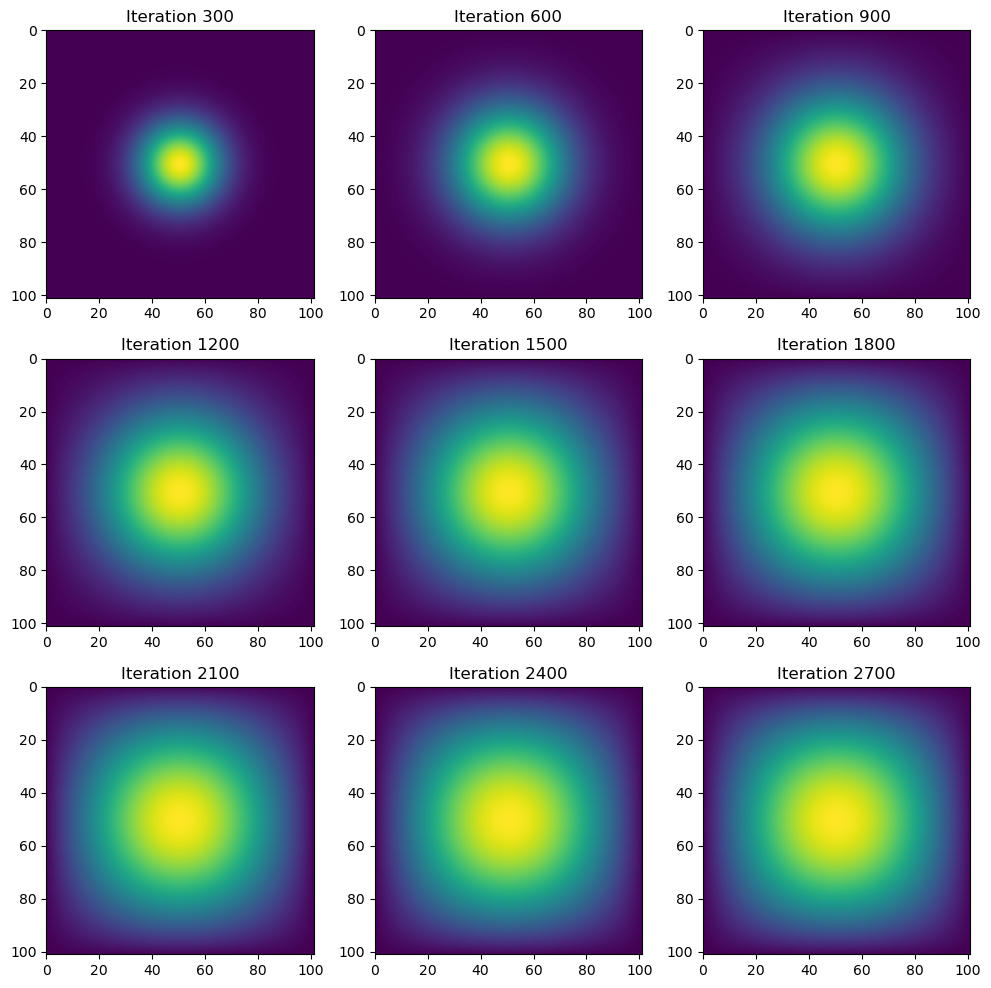

In [13]:
# Store intermediate solutions
simulations = []  # Save the initial state
u = u0  # Working copy of the grid

# Warm-up run (small number of iterations to compile the function)
for _ in range(10):
    u = advance_time_jax(u, epsilon)

# Main simulation
start_time = time.time()
for i in range(1, iterations + 1):
    u = advance_time_jax(u, epsilon)
    if i % interval == 0:
        simulations.append(np.array(u))  # Save the current state

end_time = time.time()
print(f"Simulation time (JAX): {end_time - start_time} seconds")

# Generate visualization
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    if i < len(simulations):
        im = ax.imshow(simulations[i], cmap='viridis', origin='lower', extent=[0, N, N, 0])
        ax.set_title(f"Iteration {(i+1) * interval}")
        ax.axis('on')
plt.tight_layout()
plt.show()

Wow! We see that this method only takes 0.05 seconds, which is even faster than 0.1 seconds! Compared to the 30+ seconds compilation time in the first method, this approach demonstrates a significant improvement in computational performance. By leveraging JAX's JIT compilation and vectorized operations, we’ve achieved a highly efficient simulation. 

# Comparing the Four Methods

After implementing these four methods, we have observed a great fluctuation in the time needed to compile the heat diffusion simulations. Let's compare the compilation time for the four methods:

| Method                          | Runtime |
|---------------------------------|----------------------------------|
| Matrix-Vector Multiplication    | 36.65 seconds                     |
| Sparse Matrix-Vector Multiplication | 0.58 seconds                  |
| Direct NumPy Operations         | 0.20 seconds                     |
| JAX with JIT Compilation        | 0.05 seconds                   |

The matrix-vector multiplication method is the slowest, taking over 30 seconds due to its high computational overhead. The sparse matrix method improves performance significantly, reducing runtime to 0.58 seconds. The NumPy method is simpler and achieves a runtime of 0.20 seconds, making it a good balance between speed and ease of use. Finally, JAX with JIT compilation is the fastest, with a runtime of just 0.05 seconds, while remaining relatively easy to implement.

Thus, different methods can drastically impact performance, and choosing the right approach can make a huge difference in both speed and simplicity!